In [3]:
%pip install pymilvus
%pip install numpy matplotlib


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
from dotenv import load_dotenv
# from pymilvus import connections

# # If using Docker standalone Milvus
# connections.connect("default", host="127.0.0.1", port="19530")

from pymilvus import connections

load_dotenv(override=True, dotenv_path="../.env.local")

milvus_uri = os.getenv("MILVUS_URI")
milvus_token = os.getenv("MILVUS_API_KEY")


connections.connect(
    alias="default",
    uri=milvus_uri,
    token=milvus_token
)

print("Connected to Milvus on Zilliz Cloud")

Connected to Milvus on Zilliz Cloud


In [5]:
from pymilvus import utility

utility.list_collections()

['test_collection', 'policy_docs_collection', 'demo_collection']

In [6]:
from pymilvus import Collection

collection = Collection("demo_collection")
collection.load()

collection.schema

{'auto_id': True, 'description': '', 'fields': [{'name': 'primary_key', 'description': 'The Primary Key', 'type': <DataType.INT64: 5>, 'is_primary': True, 'auto_id': True}, {'name': 'vector', 'description': '', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 4}}, {'name': 'title', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 200}}], 'enable_dynamic_field': True, 'enable_namespace': False}

In [7]:
results = collection.query(
    expr="id >= 0",
    output_fields=["id", "title", "embedding"],
    limit=5
)

results

data: [], extra_info: {'cost': 6, 'scanned_remote_bytes': 1048576, 'scanned_total_bytes': 2097152, 'cache_hit_ratio': 0.5}

In [18]:
import numpy as np

data = [
    [np.random.random(4).tolist()],            # vector FIRST
    ["Milvus makes vector search scalable"]     # title SECOND
]

collection.insert(data)
collection.flush()

In [9]:
collection.delete(expr="id == 0x00000222C5578280")
collection.flush()

updated_data = [
    [
        [0.7000895, 0.022113776, 0.48144588, 0.23203984]
    ],  # ← list of vectors (1 row)
    [
        "Deep Learning (Updated)"
    ]   # ← list of titles (1 row)
]

result = collection.insert(updated_data)
collection.flush()

new_id = result.primary_keys[0]
print(f"Record updated. New ID generated: {new_id}")

Record updated. New ID generated: 463705194119036147


In [10]:
collection.delete(expr="id == 463705165204325161")
collection.flush()

print("Record deleted")


results = collection.query(
    expr="id == 463705164234735372",
    output_fields=["id", "title", "embedding"],
    limit=5
)

results

Record deleted


data: [], extra_info: {'cost': 1, 'scanned_remote_bytes': 0, 'scanned_total_bytes': 2097152, 'cache_hit_ratio': 1.0}

In [11]:
query_vector = np.random.random(4).tolist()
print(f"Query Vector: {query_vector}")
search_results = collection.search(
    data=[query_vector],
    anns_field="vector",
    param={"metric_type": "COSINE", "params": {"nprobe": 10}},
    limit=50,
    output_fields=["title"]
)

for hit in search_results[0]:
    print(f"id={hit.id}, score={hit.score}, title={hit.entity.get('title')}")

Query Vector: [0.2406533429139588, 0.42055644052752816, 0.9336380147370543, 0.48165662781930885]


id=463705166036121183, score=0.974216639995575, title=Milvus makes vector search scalable {np.random.randint}
id=463705165204323053, score=0.9567743539810181, title=Milvus makes vector search scalable
id=463705165204322990, score=0.9567089676856995, title=Milvus makes vector search scalable
id=463705166036111208, score=0.9472466707229614, title=Milvus makes vector search scalable
id=463705166036121409, score=0.883428692817688, title=Milvus makes vector search scalable {num}
id=463705165204324243, score=0.8638406991958618, title=Milvus makes vector search scalable {num}
id=463705165204323965, score=0.859610915184021, title=Milvus makes vector search scalable 
id=463705165204324527, score=0.8572924733161926, title=Milvus makes vector search scalable {num}
id=463705165204311949, score=0.818637490272522, title=Milvus makes vector search scalable
id=463705165204323836, score=0.7844207286834717, title=Milvus makes vector search scalable {np.random.randint}
id=463705165204311983, score=0.7250

count: data: ["{'vector': [0.3577929139137268, 0.8773033618927002, 0.41825219988822937, 0.6708528995513916], 'title': 'Milvus makes vector search scalable', 'primary_key': 463705165204311949}", "{'vector': [0.7000895142555237, 0.022113775834441185, 0.48144587874412537, 0.23203983902931213], 'title': 'Deep Learning (Updated)', 'primary_key': 463705165204311983}", "{'vector': [0.5084807872772217, 0.6928585171699524, 0.902072548866272, 0.8201499581336975], 'title': 'Milvus makes vector search scalable', 'primary_key': 463705165204322990}", "{'vector': [0.6632097363471985, 0.7080084085464478, 0.9971493482589722, 0.5935584902763367], 'title': 'Milvus makes vector search scalable', 'primary_key': 463705165204323053}", "{'vector': [0.6910471320152283, 0.6383509635925293, 0.37190020084381104, 0.516772985458374], 'title': 'Milvus makes vector search scalable {np.random.randint}', 'primary_key': 463705165204323836}", "{'vector': [0.15309128165245056, 0.469379723072052, 0.3041365146636963, 0.1744

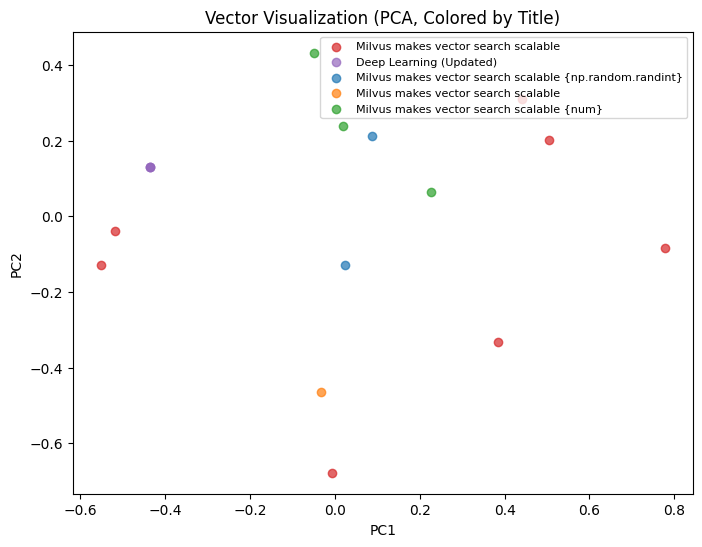

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1️⃣ Pull vectors + titles from Milvus
schema = collection.schema
# 2. Iterate through fields to find the vector field and its 'dim'
for field in schema.fields:
    # Check for FLOAT_VECTOR or BINARY_VECTOR types
    if "VECTOR" in str(field.dtype):
        # Retrieve the dimension from the field's parameters
        dimension = field.params.get('dim')
        print(f"Field Name: {field.name}")
        print(f"Vector Dimensions: {dimension}")

data = collection.query(
    expr="primary_key >= 0",
    output_fields=["vector", "title"],
    limit=100
)

print(f"count: {data}")

vectors = np.array([d["vector"] for d in data])
titles = [d["title"] for d in data]

# Verify we have enough samples for 2D PCA
if len(vectors) < 2:
    print(f"Not enough data for PCA (Found: {len(vectors)}). Need at least 2.")
else:
    # 2️⃣ Reduce vectors to 2D using PCA
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(vectors)
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(vectors)

# 3️⃣ Color points by title
unique_titles = list(set(titles))
colors = plt.cm.tab10(range(len(unique_titles)))
color_map = dict(zip(unique_titles, colors))

plt.figure(figsize=(8,6))

for i, title in enumerate(titles):
    plt.scatter(
        reduced[i, 0],
        reduced[i, 1],
        color=color_map[title],
        alpha=0.7,
        label=title
    )

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=8)

plt.title("Vector Visualization (PCA, Colored by Title)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()